In [ ]:
## librerias requeridas

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta


In [ ]:
pd.set_option('display.max_columns', 500)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.width', 1000)
pd.set_option('display.memory_usage', True)

In [ ]:
## COSECHAS

# cosechas 1
df1 = pd.read_parquet('./ABT/Prepoc_MX_2023-06-11.parquet')
# cosechas 2
df2 = pd.read_parquet('./ABT/Prepoc_MX_2023-06-18.parquet')
# cosechas 3
df3 = pd.read_parquet('./ABT/Prepoc_MX_2023-06-25.parquet')
# cosechas 4
df4 = pd.read_parquet('./ABT/Prepoc_MX_2023-07-02.parquet')


In [ ]:
## TARGETS

#target 1
tg1 = pd.read_parquet('./ABT/Target_MX_2023-06-11.parquet')
#target 1
tg2 = pd.read_parquet('./ABT/Target_MX_2023-06-18.parquet')
#target 1
tg3 = pd.read_parquet('./ABT/Target_MX_2023-06-25.parquet')
#target 1
tg4 = pd.read_parquet('./ABT/Target_MX_2023-07-02.parquet')


In [ ]:
## unir las cuatro cosechas

dfs = [df1, df2, df3, df4]

df = pd.concat(dfs, ignore_index=True)

In [ ]:
## unir los cuatro targets

tgs = [tg1, tg2, tg3, tg4]

tg = pd.concat(tgs, ignore_index=True)

In [ ]:
## eliminar la columna country del target

tg = tg.drop('country_cd', axis=1)

In [ ]:
df = df.sort_values(by=["cbs_reg_user_id_cd", "week_dt"])
tg = tg.sort_values(by=["cbs_reg_user_id_cd", "week_dt"])

In [ ]:
df = pd.merge(df, tg, how="left", on=["cbs_reg_user_id_cd", "week_dt"])

In [ ]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
df = limpiar_nombres_columnas(df)

In [ ]:
#listar las columnas del dataframe

def nombres_de_columnas(dataframe):
    return dataframe.columns.tolist()

# Supongamos que tu DataFrame se llama 'df'
# Puedes ajustar el nombre según el que hayas utilizado

nombres_columnas = nombres_de_columnas(df)

# Imprimir los nombres de las columnas
print(f'Nombres de columnas: {nombres_columnas}')


In [ ]:
df.shape

In [ ]:
## ## Con 60 dias de antiguedad

df=df[(df['tenure_day']>=60)]
df.shape

In [ ]:
##lista de variables de input
X = df_source[['tenure_day',
'tenure_m']]


In [ ]:
Y = df[['target']] 

In [ ]:
def calcular_porcentaje_valor_1(columna):
    """
    Calcula el porcentaje de ocurrencia del valor 1 en una columna dicotómica.

    Parameters:
    - columna: Columna con valores binarios (0 o 1).

    Returns:
    - Porcentaje de ocurrencia del valor 1.
    """

    total_registros = len(columna)
    ocurrencias_valor_1 = columna.sum()

    porcentaje_valor_1 = (ocurrencias_valor_1 / total_registros) * 100

    return porcentaje_valor_1
porcentaje_1 = calcular_porcentaje_valor_1(Y['target'])
porcentaje_1

## ENTRENAMIENTO

In [ ]:
# Dividir el conjunto de datos en conjuntos de entrenamiento (80%) y prueba (20%)
# X_train: características de entrenamiento, X_test: características de prueba
# y_train: etiquetas de entrenamiento, y_test: etiquetas de prueba
# Se utiliza un 20% de los datos para prueba, y se fija la semilla aleatoria en 88 para reproducibilidad.

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 88) 

In [ ]:
fit_parameters = {
    "early_stopping_rounds": 30,           # Número de rondas para detener el entrenamiento si no hay mejoras
    "eval_metric": 'logloss',              # Métrica de evaluación a utilizar (en este caso, logloss)
    "eval_set": [(X_test, y_test)],        # Conjunto de datos de prueba para la evaluación durante el entrenamiento
    'eval_names': ['valid'],               # Nombre asignado al conjunto de evaluación
    'verbose': 100,                        # Nivel de detalle en la salida durante el entrenamiento
}

In [ ]:
# Parámetros para la búsqueda aleatoria de hiperparámetros
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50, 100, 150, 300, 400, 500, 510, 520],
    # Número de estimadores (árboles) a probar

    "num_leaves": [2, 3, 4, 6, 10, 20, 25, 28, 30, 31, 32, 33, 35, 40, 45],
    # Número máximo de nodos hoja en un árbol

    "max_depth": [10, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 35, 100, 125, 150, 170, 200, 250, 300, 400],
    # Profundidad máxima de un árbol

    "colsample_bytree": [0.50, 0.55, 0.6, 0.65, 0.68, 0.70, 0.71, 0.80, 0.81, 0.84, 0.85, 0.86, 0.9],
    # Fracción de características a considerar en cada árbol

    "min_child_weight": [0.001, 0.002, 0.0025, 0.0026, 0.0027, 0.003, 0.004, 0.005, 0.007, 0.008, 0.009],
    # Peso mínimo necesario para crear un nuevo nodo en el árbol

    "learning_rate": [0.1, 0.02, 0.03, 0.04, 0.07, 0.005, 0.003, 0.001],
    # Tasa de aprendizaje del modelo

    'subsample': [1],
    # Fracción de muestras a utilizar para el entrenamiento de cada árbol

    "objective": ['binary'],
    # Tipo de problema a resolver (clasificación binaria en este caso)

    "importance_type": ["gini", "entropy"],
    # Tipo de importancia de las características

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # Tipo de boosting a probar
    
    "is_unbalance": ['True'],}


In [ ]:
# Parámetros para la búsqueda aleatoria de hiperparámetros
param_testeo = {
    "n_estimators": [5, 10, 15, 20, 25, 30, 35, 50],
    # Número de estimadores (árboles) a probar

    "num_leaves": [ 28, 29, 30, 31, 32, 33],
    # Número máximo de nodos hoja en un árbol

    "max_depth": [ 16, 17, 18, 19, 20, 21, 22, 23, 24],
    # Profundidad máxima de un árbol

    "colsample_bytree": [ 0.58, 0.6, 0.62, 0.68],
    # Fracción de características a considerar en cada árbol

    "min_child_weight": [ 0.008, 0.0085 ,0.009, 0.0095],
    # Peso mínimo necesario para crear un nuevo nodo en el árbol

    "learning_rate": [0.1, 0.02, 0.04, 0.05,0.06, 0.07, 0.005, 0.001],
    # Tasa de aprendizaje del modelo

    'subsample': [1],
    # Fracción de muestras a utilizar para el entrenamiento de cada árbol

    "objective": ['binary'],
    # Tipo de problema a resolver (clasificación binaria en este caso)

    "importance_type": ["gini", "entropy"],
    # Tipo de importancia de las características

    "boosting_type": ["dart", "goss", "rf", "gbdt"],
    # Tipo de boosting a probar
    
    "is_unbalance": ['True'],}


In [ ]:
# "scale_pos_weight": [2, 5, 10, 20, 24],
# "is_unbalance": ['True']


In [ ]:
# Número de combinaciones de hiperparámetros a probar durante la búsqueda aleatoria
n_HP_points_to_test = 100


In [ ]:
def entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87):
    """
    Entrena un modelo utilizando LightGBM con búsqueda aleatoria de hiperparámetros.

    Parameters:
    - X: Características del conjunto de datos.
    - Y: Etiquetas del conjunto de datos.
    - fit_parameters: Parámetros para el entrenamiento y evaluación del modelo.
    - param_testeo: Parámetros para la búsqueda aleatoria de hiperparámetros.
    - n_HP_points_to_test: Número de combinaciones de hiperparámetros a probar (predeterminado: 100).
    - random_state: Semilla aleatoria para reproducibilidad (predeterminado: 87).

    Returns:
    - Objeto de resultados de RandomizedSearchCV.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=random_state)

    # Limpiar y estandarizar los nombres de las columnas (llamando a la función anterior)
    X_train = limpiar_nombres_columnas(X_train)
    X_test = limpiar_nombres_columnas(X_test)

    # Crear un clasificador LightGBM y realizar una búsqueda aleatoria de hiperparámetros
    lgbm = LGBMClassifier(random_state=random_state)
    result_trainRandom = RandomizedSearchCV(
                        estimator=lgbm, 
                        param_distributions=param_testeo, 
                        n_iter=n_HP_points_to_test,
                        scoring='f1_micro',
                        cv=3,
                        refit=True,
                        random_state=random_state,
                        verbose=True)

    # Entrenar el modelo utilizando los datos de entrenamiento y los parámetros de ajuste
    result_trainRandom.fit(X_train, y_train, **fit_parameters)

    return result_trainRandom
   


In [ ]:
#entrenar_modelo_con_busqueda_aleatoria(X, Y, fit_parameters, param_testeo, n_HP_points_to_test=100, random_state=87)

In [ ]:
#experimento 1
lgb_classifier = LGBMClassifier(subsample= 1, objective = 'binary', num_leaves= 31, min_child_weight=0.009, max_depth= 19, learning_rate= 0.05, importance_type='entropy', colsample_bytree= 0.6 ,boosting_type='dart', is_unbalance='True', num_boost_round = 30)

In [ ]:
lgb_classifier.fit(np.array(X_train), y_train)
lbg_predictions_labels = lgb_classifier.predict(X_train)

In [ ]:
# modelo train
data1_f_data_pred_rf= lgb_classifier.predict(X)     
probab_rf = lgb_classifier.predict_proba(X)

score_rf=np.delete(probab_rf, np.s_[0], axis=1) 
Y_c=Y.copy()
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

In [ ]:
# Realizar predicciones con el modelo entrenado en el conjunto de entrenamiento
data1_f_data_pred_rf = lgb_classifier.predict(X)

# Obtener las probabilidades predichas para la clase positiva (clase 1) del modelo
probab_rf = lgb_classifier.predict_proba(X)

# Extraer las puntuaciones (probabilidades) asociadas con la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Crear una copia de las etiquetas verdaderas (Y) para análisis adicional
Y_c = Y.copy()

# Agregar las predicciones y las puntuaciones del modelo a las etiquetas verdaderas
Y_c['preds_rf'] = data1_f_data_pred_rf
Y_c['score_rf'] = score_rf

# Los datos ahora contienen etiquetas verdaderas, predicciones y puntuaciones del modelo
# Puedes utilizar estos resultados para realizar análisis y evaluar el rendimiento del modelo.


In [ ]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT INV CHURN TRAIN:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC INV CHURN TRAIN:')
print(roc_auc_score(Y_c[['target']], Y_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'].ravel())
print('KS INV CHURN TRAIN:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_c[['target']], Y_c['preds_rf'])
recall = recall_score(Y_c[['target']], Y_c['preds_rf'])

print('Precision INV CHURN TRAIN:')
print(precision)
print('Recall INV CHURN TRAIN:')
print(recall)

# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_c['score_rf'], q=10, duplicates='drop').astype(str)
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['CHURNINV_DECILE'] = np.nan
Y_c['CHURNINV_DECILE'] = Y_c['CHURNINV_DECILE'].astype('Int32')
Y_c['CHURNINV_DECILE'] = percentiles
print('INV CHURN CAPTURA 30%:')
print(sum(Y_c[Y_c['CHURNINV_DECILE'] < 4]['target']) / sum(Y_c['target']))


In [ ]:
DECILES_T = pd.crosstab(Y_c['CHURNINV_DECILE'], Y_c['target'])

In [ ]:
DECILES_T

In [ ]:
DECILES_T.plot.bar(stacked=False, rot=0,subplots=True)

## TESTEO ##

In [ ]:
tes1 = pd.read_parquet('./ABT/Prepoc_MX_2023-11-19.parquet')

In [ ]:
tes2 = pd.read_parquet('./ABT/Prepoc_MX_2023-11-26.parquet')

In [ ]:
tes3 = pd.read_parquet('./ABT/Prepoc_MX_2023-12-03.parquet')

In [ ]:
tes4 = pd.read_parquet('./ABT/Prepoc_MX_2023-12-10.parquet')

In [ ]:
## unir las cuatro cosechas

tes = [tes1, tes2, tes3, tes4]

tes = pd.concat(tes, ignore_index=True)

In [ ]:
## TARGETS de TESTE0

#target 1
tgt1 = pd.read_parquet('./ABT/Target_MX_2023-11-19.parquet')
#target 1
tgt2 = pd.read_parquet('./ABT/Target_MX_2023-11-26.parquet')
#target 1
tgt3 = pd.read_parquet('./ABT/Target_MX_2023-12-03.parquet')
#target 1
tgt4 = pd.read_parquet('./ABT/Target_MX_2023-12-10.parquet')

In [ ]:
tgt = [tgt1, tgt2, tgt3, tgt4]

tgt = pd.concat(tgt, ignore_index=True)

In [ ]:
tgt = tgt.drop('country_cd', axis=1)

In [ ]:
#ordenar las bases antes de unirlas (no es obligatorio)
tes = tes.sort_values(by=["cbs_reg_user_id_cd", "week_dt"])
tgt = tgt.sort_values(by=["cbs_reg_user_id_cd", "week_dt"])

In [ ]:
testeo = pd.merge(tes, tgt, how="left", on=["cbs_reg_user_id_cd", "week_dt"])

In [ ]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo = limpiar_nombres_columnas(testeo)

In [ ]:
testeo = testeo
testeo['ID']=testeo['cbs_reg_user_id_cd']
testeo = testeo.set_index('ID')  
#testeo=testeo.round(2)

 
print ("Dataset Length: ", len(testeo)) 
print ("Dataset Shape: ", testeo.shape)

In [ ]:
testeo['target'].value_counts(dropna=False)

In [ ]:
## ## Con 60 dias de antiguedad

testeo=testeo[(testeo['tenure_day']>=60)]
testeo.shape

In [ ]:
testeo['target'].value_counts(dropna=False)

In [ ]:
## Variables del modelo
X_TESTEO = testeo[['tenure_day',
'tenure_m']]

In [ ]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO = testeo[['target']]

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [ ]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

In [ ]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_TESTEO_c[['target']])
percentages, gains = cumulative_gain_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT INV CHURN TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC INV CHURN TESTEO:')
print(roc_auc_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'].ravel())
print('KS INV CHURN TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
recall = recall_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
print('Precision INV CHURN TESTEO:')
print(precision)
print('Recall INV CHURN TESTEO:')
print(recall)

# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop').astype(str)
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['CHURNINV_DECILE'] = np.nan
Y_TESTEO_c['CHURNINV_DECILE'] = Y_TESTEO_c['CHURNINV_DECILE'].astype('Int32')
Y_TESTEO_c['CHURNINV_DECILE'] = percentiles
print('INV CHURN CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['CHURNINV_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')


In [ ]:
DECILES = pd.crosstab(Y_TESTEO_c['CHURNINV_DECILE'], Y_TESTEO_c['target'])

In [ ]:
DECILES

In [ ]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [ ]:
# Guardando las importancias de las características (feature importance) en un archivo de texto
# La importancia se mide en términos de ganancia ('gain') según el clasificador LightGBM
# Se utiliza la función 'np.savetxt' para escribir en un archivo de texto
# El archivo se guarda en la ruta './SCORES/importance_1.txt'
# Se utiliza 'lgb_classifier.booster_.feature_importance' para obtener las importancias de las características
# Se especifica el formato de los datos en el archivo como números de punto flotante ('%f')

np.savetxt('./SCORES/importance_78.txt', lgb_classifier.booster_.feature_importance(importance_type='gain'),fmt='%f')

##TESTEAR TODA LA BASE (sin restricciones de tenure)

In [ ]:
tes1 = pd.read_parquet('./ABT/Prepoc_MX_2023-11-19.parquet')

In [ ]:
tes2 = pd.read_parquet('./ABT/Prepoc_MX_2023-11-26.parquet')

In [ ]:
tes3 = pd.read_parquet('./ABT/Prepoc_MX_2023-12-03.parquet')

In [ ]:
tes4 = pd.read_parquet('./ABT/Prepoc_MX_2023-12-10.parquet')

In [ ]:
## unir las cuatro cosechas

tes = [tes1, tes2, tes3, tes4]

tes = pd.concat(tes, ignore_index=True)

In [ ]:
## TARGETS de TESTE0

#target 1
tgt1 = pd.read_parquet('./ABT/Target_MX_2023-11-19.parquet')
#target 1
tgt2 = pd.read_parquet('./ABT/Target_MX_2023-11-26.parquet')
#target 1
tgt3 = pd.read_parquet('./ABT/Target_MX_2023-12-03.parquet')
#target 1
tgt4 = pd.read_parquet('./ABT/Target_MX_2023-12-10.parquet')

In [ ]:
tgt = [tgt1, tgt2, tgt3, tgt4]

tgt = pd.concat(tgt, ignore_index=True)

In [ ]:
tgt = tgt.drop('country_cd', axis=1)

In [ ]:
#ordenar las bases antes de unirlas (no es obligatorio)
tes = tes.sort_values(by=["cbs_reg_user_id_cd", "week_dt"])
tgt = tgt.sort_values(by=["cbs_reg_user_id_cd", "week_dt"])

In [ ]:
tgt['target'].value_counts(dropna=False)

In [ ]:
testeo_f = pd.merge(tes1, tgt1, how="left", on=["cbs_reg_user_id_cd", "week_dt"])

In [ ]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe
    
testeo_f = limpiar_nombres_columnas(testeo_f)

In [ ]:
testeo_f['cbs_reg_user_id_cd'] = testeo_f['cbs_reg_user_id_cd'].astype(int)

In [ ]:
testeo_f = testeo_f
testeo_f['ID']=testeo_f['cbs_reg_user_id_cd']
testeo_f = testeo_f.set_index('ID')  
#testeo=testeo.round(2)

 
print ("Dataset Length: ", len(testeo_f)) 
print ("Dataset Shape: ", testeo_f.shape)

Dataset Length:  84947
Dataset Shape:  (84947, 561)


In [ ]:
testeo_f['target'].value_counts(dropna=False)

0    82154
1     2793
Name: target, dtype: int64

In [ ]:
X_TESTEO_f = testeo_f[['tenure_day',
'tenure_m']]

In [ ]:

# Extrayendo la columna 'target' del DataFrame 'testeo' y creando un nuevo DataFrame 'Y_TESTEO'
Y_TESTEO_f = testeo_f[['target']]

# Prediciendo la variable objetivo para el conjunto de datos de prueba 'X_TESTEO' utilizando el clasificador LightGBM
testeo_data_pred_rf = lgb_classifier.predict(X_TESTEO_f)

# Prediciendo las probabilidades de clase para cada observación en 'X_TESTEO' utilizando el clasificador LightGBM
probab_rf = lgb_classifier.predict_proba(X_TESTEO_f)

# Eliminando la primera columna (se asume que son las probabilidades de la clase negativa) de las probabilidades predichas
# Se asume que la segunda columna contiene las probabilidades para la clase positiva
score_rf = np.delete(probab_rf, np.s_[0], axis=1)


In [ ]:
# Creando una copia del DataFrame 'Y_TESTEO' para preservar los datos originales
Y_TESTEO_c = Y_TESTEO_f.copy()

# Agregando una nueva columna 'preds_rf' al DataFrame copiado con las predicciones del clasificador LightGBM
Y_TESTEO_c['preds_rf'] = testeo_data_pred_rf

# Agregando una nueva columna 'score_rf' al DataFrame copiado con las probabilidades de la clase positiva
Y_TESTEO_c['score_rf'] = score_rf

In [ ]:
# Calcular la curva de ganancia acumulativa y el LIFT del modelo en el conjunto de entrenamiento
classes = np.unique(Y_TESTEO_c[['target']])
percentages, gains = cumulative_gain_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT INV CHURN TESTEO:')
print(gains[indice])

# Calcular el área bajo la curva ROC del modelo en el conjunto de entrenamiento
print('ROC INV CHURN TESTEO:')
print(roc_auc_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf']))

# Calcular la estadística KS del modelo en el conjunto de entrenamiento
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_TESTEO_c[['target']], Y_TESTEO_c['score_rf'].ravel())
print('KS INV CHURN TESTEO:')
print(ks_statistic)

# Calcular la precisión y el recall del modelo en el conjunto de entrenamiento
precision = precision_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
recall = recall_score(Y_TESTEO_c[['target']], Y_TESTEO_c['preds_rf'])
print('Precision INV CHURN TESTEO:')
print(precision)
print('Recall INV CHURN TESTEO:')
print(recall)

# Dividir las predicciones en deciles y calcular la captura del 30% en el conjunto de entrenamiento
percentiles = pd.qcut(Y_TESTEO_c['score_rf'], q=10, duplicates='drop').astype(str)
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_TESTEO_c['CHURNINV_DECILE'] = np.nan
Y_TESTEO_c['CHURNINV_DECILE'] = Y_TESTEO_c['CHURNINV_DECILE'].astype('Int32')
Y_TESTEO_c['CHURNINV_DECILE'] = percentiles
print('INV CHURN CAPTURA 30%:')
print(sum(Y_TESTEO_c[Y_TESTEO_c['CHURNINV_DECILE'] < 4]['target']) / sum(Y_TESTEO_c['target']))
#Y_TESTEO_c.to_csv(r'./SCORES/primera_prueba.csv')


LIFT INV CHURN TESTEO:
5.924621422064712
ROC INV CHURN TESTEO:
0.7788750674518938
KS INV CHURN TESTEO:
0.6690402446529624
Precision INV CHURN TESTEO:
0.1703156358328772
Recall INV CHURN TESTEO:
0.6684568564267812
INV CHURN CAPTURA 30%:
0.9280343716433942


/databricks/python/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:115: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
DECILES = pd.crosstab(Y_TESTEO_c['CHURNINV_DECILE'], Y_TESTEO_c['target'])

In [ ]:
DECILES

target,0,1
CHURNINV_DECILE,,
1,6840,1655
2,7936,558
3,8114,379
4,8248,158
5,8557,28
6,8406,8
7,8423,3
8,8620,1
9,8325,1


array([<AxesSubplot:title={'center':'0'}, xlabel='CHURNINV_DECILE'>,
       <AxesSubplot:title={'center':'1'}, xlabel='CHURNINV_DECILE'>],
      dtype=object)

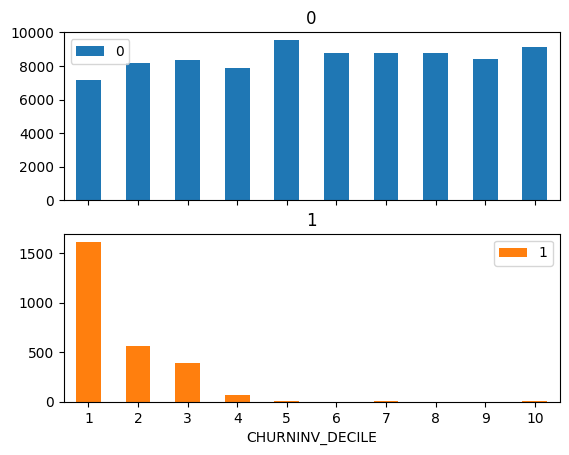

In [ ]:
DECILES.plot.bar(stacked=False, rot=0,subplots=True)

In [ ]:
Y_TESTEO_c.head()

,target,preds_rf,score_rf,CHURNINV_DECILE
ID,,,,
25473450,0,0,0.021569,8
47048254,0,0,0.142731,4
50617237,0,0,0.022059,8
59198106,0,0,0.254423,4
38690563,0,0,0.024852,7


In [ ]:
Y_TESTEO_c.dtypes

target               int64
preds_rf             int64
score_rf           float64
CHURNINV_DECILE      int64
dtype: object

In [ ]:
testeo_f2= testeo_f[['cbs_reg_user_id_cd', 'tenure_day', 'tenure_m','days_last_paid','week_dt']]

In [ ]:
testeo_f2 = testeo_f2.reset_index()

In [ ]:
testeo_f2.head()

,ID,cbs_reg_user_id_cd,tenure_day,tenure_m,days_last_paid,week_dt
0,25473450,25473450,678,23,3.0,2023-12-10
1,47048254,47048254,210,7,19.0,2023-12-10
2,50617237,50617237,294,10,14.0,2023-12-10
3,59198106,59198106,184,6,24.0,2023-12-10
4,38690563,38690563,442,15,8.0,2023-12-10


In [ ]:
testeo_f2.dtypes

ID                     object
cbs_reg_user_id_cd     object
tenure_day              int64
tenure_m                int64
days_last_paid        float64
week_dt                object
dtype: object

In [ ]:
Y_TESTEO_c['ID'] = Y_TESTEO_c['ID'].astype(int)

---------------------------------------------------------------------------
KeyError                                  Traceback (most recent call last)
File /databricks/python/lib/python3.10/site-packages/pandas/core/indexes/base.py:3629, in Index.get_loc(self, key, method, tolerance)
   3628 try:
-> 3629     return self._engine.get_loc(casted_key)
   3630 except KeyError as err:

File /databricks/python/lib/python3.10/site-packages/pandas/_libs/index.pyx:136, in pandas._libs.index.IndexEngine.get_loc()

File /databricks/python/lib/python3.10/site-packages/pandas/_libs/index.pyx:163, in pandas._libs.index.IndexEngine.get_loc()

File pandas/_libs/hashtable_class_helper.pxi:5198, in pandas._libs.hashtable.PyObjectHashTable.get_item()

File pandas/_libs/hashtable_class_helper.pxi:5206, in pandas._libs.hashtable.PyObjectHashTable.get_item()

KeyError: 'ID'

The above exception was the direct cause of the following exception:

KeyError                                  Traceback (most recent

In [ ]:
testeo_f2['ID'] = testeo_f2['ID'].astype(int)

In [ ]:
testeo_all10dec2023 = pd.merge(testeo_f2, Y_TESTEO_c, how="left", on=["ID"])

In [ ]:
testeo_all10dec2023.head()

,ID,cbs_reg_user_id_cd,tenure_day,tenure_m,days_last_paid,week_dt,target,preds_rf,score_rf,CHURNINV_DECILE
0,25473450,25473450,678,23,3.0,2023-12-10,0,0,0.021569,8
1,47048254,47048254,210,7,19.0,2023-12-10,0,0,0.142731,4
2,50617237,50617237,294,10,14.0,2023-12-10,0,0,0.022059,8
3,59198106,59198106,184,6,24.0,2023-12-10,0,0,0.254423,4
4,38690563,38690563,442,15,8.0,2023-12-10,0,0,0.024852,7


In [ ]:
testeo_all10dec2023= testeo_all10dec2023[['cbs_reg_user_id_cd', 'target','preds_rf','score_rf','CHURNINV_DECILE','tenure_m']]

In [ ]:
testeo_all10dec2023.to_csv('testeo_60Mx10dec2023.csv')